# Combined Wavefront Calculation
In this notebook we aspire to (1) layout the calculation we will use for the wavefront and (2) validate that this choice is reasonable

In [174]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import bisect
from batoid.utils import fieldToDirCos
from batoid.psf import dkdu, reciprocalLatticeVectors

import galsim
import batoid
import multiprocessing

### Make Atmosphere

In [11]:
def _vkSeeing(r0_500, wavelength, L0):
    # von Karman profile FWHM from Tokovinin fitting formula
    kolm_seeing = galsim.Kolmogorov(r0_500=r0_500, lam=wavelength).fwhm
    r0 = r0_500 * (wavelength/500)**1.2
    arg = 1. - 2.183*(r0/L0)**0.356
    factor = np.sqrt(arg) if arg > 0.0 else 0.0
    return kolm_seeing*factor


def _seeingResid(r0_500, wavelength, L0, targetSeeing):
    return _vkSeeing(r0_500, wavelength, L0) - targetSeeing


def _r0_500(wavelength, L0, targetSeeing):
    """Returns r0_500 to use to get target seeing."""
    r0_500_max = min(1.0, L0*(1./2.183)**(-0.356)*(wavelength/500.)**1.2)
    r0_500_min = 0.01
    return bisect(
        _seeingResid,
        r0_500_min,
        r0_500_max,
        args=(wavelength, L0, targetSeeing)
    )

def makeAtmosphere(
    airmass,
    rawSeeing,
    wavelength,
    rng,
    kcrit=0.2,
    screen_size=819.2,
    screen_scale=0.1,
    nproc=6
):
    targetFWHM = (
        rawSeeing/galsim.arcsec *
        airmass**0.6 *
        (wavelength/500.0)**(-0.3)
    )

    ud = galsim.UniformDeviate(rng)
    gd = galsim.GaussianDeviate(rng)

    # Use values measured from Ellerbroek 2008.
    altitudes = [0.0, 2.58, 5.16, 7.73, 12.89, 15.46]
    # Elevate the ground layer though.  Otherwise, PSFs come out too correlated
    # across the field of view.
    altitudes[0] = 0.2

    # Use weights from Ellerbroek too, but add some random perturbations.
    weights = [0.652, 0.172, 0.055, 0.025, 0.074, 0.022]
    weights = [np.abs(w*(1.0 + 0.1*gd())) for w in weights]
    weights = np.clip(weights, 0.01, 0.8)  # keep weights from straying too far.
    weights /= np.sum(weights)  # renormalize

    # Draw outer scale from truncated log normal
    L0 = 0
    while L0 < 10.0 or L0 > 100:
        L0 = np.exp(gd() * 0.6 + np.log(25.0))
    # Given the desired targetFWHM and randomly selected L0, determine
    # appropriate r0_500
    r0_500 = _r0_500(wavelength, L0, targetFWHM)

    # Broadcast common outer scale across all layers
    L0 = [L0]*6

    # Uniformly draw layer speeds between 0 and max_speed.
    maxSpeed = 20.0
    speeds = [ud()*maxSpeed for _ in range(6)]
    # Isotropically draw directions.
    directions = [ud()*360.0*galsim.degrees for _ in range(6)]

    atmKwargs = dict(
        r0_500=r0_500,
        L0=L0,
        speed=speeds,
        direction=directions,
        altitude=altitudes,
        r0_weights=weights,
        rng=rng,
        screen_size=screen_size,
        screen_scale=screen_scale
    )

    ctx = multiprocessing.get_context('fork')
    atm = galsim.Atmosphere(mp_context=ctx, **atmKwargs)

    r0_500 = atm.r0_500_effective
    r0 = r0_500 * (wavelength/500.0)**(6./5)
    kmax = kcrit/r0

    with ctx.Pool(
        nproc,
        initializer=galsim.phase_screens.initWorker,
        initargs=galsim.phase_screens.initWorkerArgs()
    ) as pool:
        atm.instantiate(pool=pool, kmax=kmax, check='phot')

    return atm

# random observation
airmass = 1.11434297245889
rawSeeing = 0.816891898166834 * galsim.arcsec
wavelength = 622.20
rng = galsim.BaseDeviate()
atm = makeAtmosphere(airmass, rawSeeing, wavelength, rng)

### Make Telescope

In [120]:
tel = batoid.Optic.fromYaml( f"LSST_r.yaml").withGloballyShiftedOptic('M2', np.array([0,1,1]) * 1e-6)

### Calculate Optics Wavefront

In [154]:
wavelength = 622.20 * 1e-9 # convert to meters
theta_x = 1 * np.pi / 180
theta_y = 1 * np.pi / 180
eps = 0.61 # lsst obscuration
reference='chief'
jmax=22
sphereRadius=None

dirCos = fieldToDirCos(theta_x, theta_y, projection='postel')
inner = eps*tel.pupilSize/2
rays = batoid.RayVector.asSpokes(
    optic=tel, wavelength=wavelength,
    inner=inner,
    dirCos=dirCos,
    rings=6,
    spokes=None,
    spacing='GQ',
)

# Trace to stopSurface to get points at which to evalue Zernikes
epRays = rays.toCoordSys(tel.stopSurface.coordSys)
tel.stopSurface.surface.intersectInPlace(epRays)

basis = galsim.zernike.zernikeBasis(
    jmax, epRays.x, epRays.y,
    R_outer=tel.pupilSize/2,
    R_inner=inner
)

if sphereRadius is None:
    sphereRadius = tel.sphereRadius

tel.traceInPlace(rays)

if np.any(rays.failed):
    raise ValueError(
        "Cannot compute zernike with Gaussian Quadrature with failed rays."
    )
if reference == 'mean':
    w = np.where(1-rays.vignetted)[0]
    point = np.mean(rays.r[w], axis=0)
elif reference == 'chief':
    chiefRay = batoid.Ray.fromStop(
        0.0, 0.0,
        backDist=tel.backDist, wavelength=wavelength,
        dirCos=dirCos,
        medium=tel.inMedium,
        stopSurface=tel.stopSurface
    )
    tel.traceInPlace(chiefRay)
    point = chiefRay.r

# Place vertex of reference sphere one radius length away from the
# intersection point.  So transform our rays into that coordinate system.
targetCoordSys = rays.coordSys.shiftLocal(
    point+np.array([0,0,sphereRadius])
)
rays.toCoordSysInPlace(targetCoordSys)

sphere = batoid.Sphere(-sphereRadius)
sphere.intersectInPlace(rays)

if reference == 'mean':
    w = np.where(1-rays.vignetted)[0]
    t0 = np.mean(rays.t[w])
elif reference == 'chief':
    chiefRay.toCoordSysInPlace(targetCoordSys)
    sphere.intersectInPlace(chiefRay)
    t0 = chiefRay.t

# Zernike coefficients are flux-weighted dot products of relative phases
# with basis.
area = np.pi*(1.-eps**2)
zer = np.dot(basis, (t0-rays.t)/wavelength*rays.flux)/area

wf_optic = zer * wavelength

In [155]:
t0-rays.t

array([-1.07515362e-07, -1.78628490e-07, -2.26450382e-07, -2.53890406e-07,
       -2.96330548e-07, -3.07422859e-07, -2.52932701e-07, -3.23566994e-07,
       -3.64339236e-07, -3.80075456e-07, -3.89746781e-07, -3.45709296e-07,
       -2.64113666e-07, -3.33393785e-07, -3.71722784e-07, -3.84793402e-07,
       -3.89649365e-07, -3.38373802e-07, -1.65028787e-07, -2.38592065e-07,
       -2.87639324e-07, -3.14513116e-07, -3.49058652e-07, -3.44395303e-07,
        1.63881516e-07,  1.15184491e-07,  8.89018636e-08,  7.48823723e-08,
        1.89969711e-08, -3.54036658e-08,  7.26505121e-07,  7.46915774e-07,
        8.00955696e-07,  8.59611895e-07,  8.46434489e-07,  7.87103914e-07,
        1.29253697e-06,  1.38747650e-06,  1.53068665e-06,  1.68532732e-06,
        1.77284279e-06,  1.78179343e-06,  1.63777747e-06,  1.77180065e-06,
        1.95907940e-06,  2.17462009e-06,  2.35753124e-06,  2.45599723e-06,
        1.74878108e-06,  1.89147116e-06,  2.08655884e-06,  2.32035056e-06,
        2.54537679e-06,  

### Calculate Combined Wavefront
We augment zernikeGQ with the wavefront from the atmosphere.

In [156]:
wavelength = 622.20 * 1e-9 # convert to meters
theta_x = 1 * np.pi / 180
theta_y = 1 * np.pi / 180
eps = 0.61 # lsst obscuration
reference='chief'
jmax=22
sphereRadius=None

dirCos = fieldToDirCos(theta_x, theta_y, projection='postel')
inner = eps*tel.pupilSize/2
rays = batoid.RayVector.asSpokes(
    optic=tel, wavelength=wavelength,
    inner=inner,
    dirCos=dirCos,
    rings=6,
    spokes=None,
    spacing='GQ',
)

lags = np.zeros(len(rays))
tsteps = 100
for t in np.linspace(0,15,tsteps):
    lags += atm.wavefront(
        rays.x, rays.y, t, (theta_x*galsim.radians, theta_y*galsim.radians)
    )
lags /= tsteps
lags *= 1e-9 # convert to meters

# Is there a better way to change the lags than copying into new ray vector? Yes, [:]
rays = batoid.RayVector.fromArrays(rays.x, rays.y, rays.z, rays.vx, rays.vy, rays.vz, 
                                   rays.t - lags, np.ones(len(rays)) * wavelength, flux=rays.flux)

# Trace to stopSurface to get points at which to evalue Zernikes
epRays = rays.toCoordSys(tel.stopSurface.coordSys)
tel.stopSurface.surface.intersectInPlace(epRays)

basis = galsim.zernike.zernikeBasis(
    jmax, epRays.x, epRays.y,
    R_outer=tel.pupilSize/2,
    R_inner=inner
)

if sphereRadius is None:
    sphereRadius = tel.sphereRadius

tel.traceInPlace(rays)

if np.any(rays.failed):
    raise ValueError(
        "Cannot compute zernike with Gaussian Quadrature with failed rays."
    )
if reference == 'mean':
    w = np.where(1-rays.vignetted)[0]
    point = np.mean(rays.r[w], axis=0)
elif reference == 'chief':
    chiefRay = batoid.Ray.fromStop(
        0.0, 0.0,
        backDist=tel.backDist, wavelength=wavelength,
        dirCos=dirCos,
        medium=tel.inMedium,
        stopSurface=tel.stopSurface
    )
    tel.traceInPlace(chiefRay)
    point = chiefRay.r

# Place vertex of reference sphere one radius length away from the
# intersection point.  So transform our rays into that coordinate system.
targetCoordSys = rays.coordSys.shiftLocal(
    point+np.array([0,0,sphereRadius])
)
rays.toCoordSysInPlace(targetCoordSys)

sphere = batoid.Sphere(-sphereRadius)
sphere.intersectInPlace(rays)

if reference == 'mean':
    w = np.where(1-rays.vignetted)[0]
    t0 = np.mean(rays.t[w])
elif reference == 'chief':
    chiefRay.toCoordSysInPlace(targetCoordSys)
    sphere.intersectInPlace(chiefRay)
    t0 = chiefRay.t

# Zernike coefficients are flux-weighted dot products of relative phases
# with basis.
area = np.pi*(1.-eps**2)
zer = np.dot(basis, (t0-rays.t)/wavelength*rays.flux)/area

wf_comb = zer * wavelength

### Optics and Combined PSFs

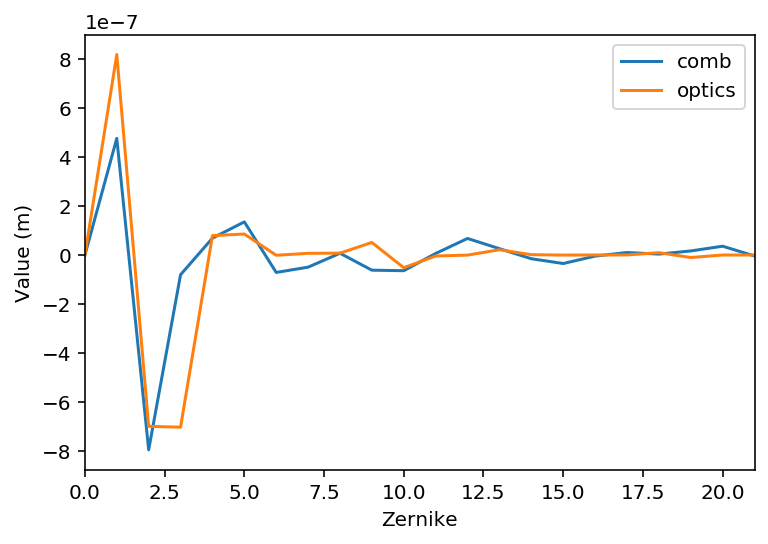

In [162]:
plt.plot(wf_comb, label='comb')
plt.plot(wf_optic, label='optics')
plt.ylabel('Value (m)')
plt.xlabel('Zernike')
plt.xlim([0,21])
plt.legend();

In [158]:
wf_optic

array([ 0.00000000e+00,  8.17934209e-07, -6.98346327e-07, -7.01712073e-07,
        7.93648516e-08,  8.58211294e-08, -6.23497383e-10,  7.22558988e-09,
        7.86404172e-09,  5.15174106e-08, -5.15232580e-08, -3.73080935e-09,
       -1.72472020e-11,  2.18204308e-08,  1.72609733e-09, -8.26373159e-15,
        4.66519168e-10,  5.10459029e-10,  9.94183169e-09, -9.94242660e-09,
        3.04988657e-10,  3.04992203e-10, -7.19742011e-09])

In [159]:
wf_comb

array([ 0.00000000e+00,  4.75982746e-07, -7.94033987e-07, -8.00327312e-08,
        6.90462128e-08,  1.35462575e-07, -7.07519297e-08, -4.91492274e-08,
        7.50565084e-09, -6.14960927e-08, -6.36819177e-08,  6.58588647e-09,
        6.77795055e-08,  2.62727129e-08, -1.48920367e-08, -3.43428307e-08,
       -4.23395209e-09,  1.05396030e-08,  4.03051291e-09,  1.68726476e-08,
        3.62508387e-08, -3.59372497e-09,  2.90726129e-10])

[[-3.84143574e-07  2.14314278e-10]
 [ 2.14310121e-10 -3.84143578e-07]]


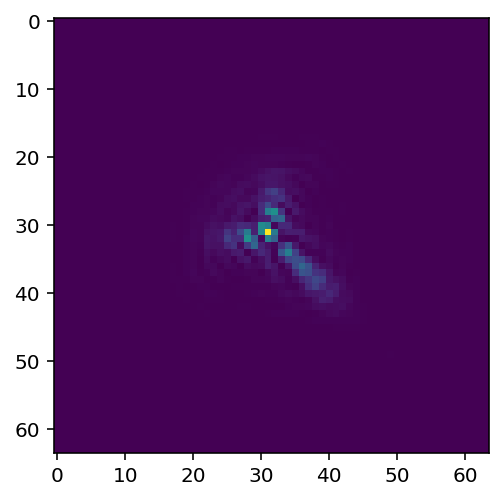

In [167]:
psf_optic = batoid.fftPSF(tel, theta_x, theta_y, wavelength, nx=32)
plt.imshow(psf_optic.array)
print(psf_optic.primitiveVectors)

In [177]:
def combined_wavefront(optic, theta_x, theta_y, wavelength,
              projection='postel', nx=32,
              sphereRadius=None, reference='mean'):
    """Compute wavefront.

    Parameters
    ----------
    optic : batoid.Optic
        Optical system
    theta_x, theta_y : float
        Field angle in radians
    wavelength : float
        Wavelength in meters
    projection : {'postel', 'zemax', 'gnomonic', 'stereographic', 'lambert', 'orthographic'}
        Projection used to convert field angle to direction cosines.
    nx : int, optional
        Size of ray grid to use.
    sphereRadius : float, optional
        The radius of the reference sphere.  Nominally this should be set to
        the distance to the exit pupil, though the calculation is usually not
        very sensitive to this.  Many of the telescopes that come with batoid
        have values for this set in their yaml files, which will be used if
        this is None.
    reference : {'chief', 'mean'}
        If 'chief', then center the output lattice where the chief ray
        intersects the focal plane.  If 'mean', then center at the mean
        non-vignetted ray intersection.

    Returns
    -------
    wavefront : batoid.Lattice
        A batoid.Lattice object containing the wavefront values in waves and
        the primitive lattice vectors of the entrance pupil grid in meters.
    """
    dirCos = fieldToDirCos(theta_x, theta_y, projection=projection)
    rays = batoid.RayVector.asGrid(
        optic=optic, wavelength=wavelength,
        nx=nx, dirCos=dirCos
    )
    
    lags = np.zeros(len(rays))
    tsteps = 100
    for t in np.linspace(0,15,tsteps):
        lags += atm.wavefront(
            rays.x, rays.y, t, (theta_x*galsim.radians, theta_y*galsim.radians)
        )
    lags /= tsteps
    lags *= 1e-9 # convert to meters

    # Is there a better way to change the lags than copying into new ray vector?
    rays = batoid.RayVector.fromArrays(rays.x, rays.y, rays.z, rays.vx, rays.vy, rays.vz, 
                                       rays.t - lags, np.ones(len(rays)) * wavelength, flux=rays.flux)
    
    if sphereRadius is None:
        sphereRadius = optic.sphereRadius

    optic.traceInPlace(rays)
    if reference == 'mean':
        w = np.where(1-rays.vignetted)[0]
        point = np.mean(rays.r[w], axis=0)
    elif reference == 'chief':
        cridx = (nx//2)*nx+nx//2 if (nx%2)==0 else (nx*nx-1)//2
        point = rays[cridx].r
    # Place vertex of reference sphere one radius length away from the
    # intersection point.  So transform our rays into that coordinate system.
    targetCoordSys = rays.coordSys.shiftLocal(
        point+np.array([0,0,sphereRadius])
    )
    rays.toCoordSysInPlace(targetCoordSys)

    sphere = batoid.Sphere(-sphereRadius)
    sphere.intersectInPlace(rays)

    if reference == 'mean':
        w = np.where(1-rays.vignetted)[0]
        t0 = np.mean(rays.t[w])
    elif reference == 'chief':
        t0 = rays[cridx].t
    arr = np.ma.masked_array(
        (t0-rays.t)/wavelength,
        mask=rays.vignetted
    ).reshape(nx, nx)
    if (nx%2) == 0:
        primitiveVectors = np.vstack(
            [[optic.pupilSize/(nx-2), 0],
             [0, optic.pupilSize/(nx-2)]]
        )
    else:
        primitiveVectors = np.vstack(
            [[optic.pupilSize/(nx-1), 0],
             [0, optic.pupilSize/(nx-1)]]
        )
    return batoid.Lattice(arr, primitiveVectors)

def fftPSF(optic, theta_x, theta_y, wavelength,
           projection='postel', nx=32, pad_factor=2,
           sphereRadius=None, reference='mean', _addedWF=None):
    """Compute PSF using FFT.

    Parameters
    ----------
    optic : batoid.Optic
        Optical system
    theta_x, theta_y : float
        Field angle in radians
    wavelength : float
        Wavelength in meters
    projection : {'postel', 'zemax', 'gnomonic', 'stereographic', 'lambert', 'orthographic'}
        Projection used to convert field angle to direction cosines.
    nx : int, optional
        Size of ray grid to use.
    pad_factor : int, optional
        Factor by which to pad pupil array.  Default: 2
    sphereRadius : float, optional
        The radius of the reference sphere.  Nominally this should be set to
        the distance to the exit pupil, though the calculation is usually not
        very sensitive to this.  Many of the telescopes that come with batoid
        have values for this set in their yaml files, which will be used if
        this is None.
    reference : {'chief', 'mean'}
        If 'chief', then center the output lattice where the chief ray
        intersects the focal plane.  If 'mean', then center at the mean
        non-vignetted ray intersection.

    Returns
    -------
    psf : batoid.Lattice
        A batoid.Lattice object containing the relative PSF values and
        the primitive lattice vectors of the focal plane grid.
    """
    wf = combined_wavefront(
        optic, theta_x, theta_y, wavelength,
        nx=nx, projection=projection,
        sphereRadius=sphereRadius, reference=reference
    )
    wfarr = wf.array
    pad_size = nx*pad_factor
    expwf = np.zeros((pad_size, pad_size), dtype=np.complex128)
    start = pad_size//2-nx//2
    stop = pad_size//2+nx//2
    expwf[start:stop, start:stop][~wfarr.mask] = \
        np.exp(2j*np.pi*wfarr[~wfarr.mask])
    psf = np.abs(np.fft.fftshift(np.fft.fft2(expwf)))**2

    primitiveU = wf.primitiveVectors
    primitiveK = dkdu(
        optic, theta_x, theta_y, wavelength,
        projection=projection
    ).dot(primitiveU)
    primitiveX = np.vstack(
        reciprocalLatticeVectors(primitiveK[0], primitiveK[1], pad_size)
    )

    return batoid.Lattice(psf, primitiveX)

[[-3.60134601e-07  2.00919635e-10]
 [ 2.00915739e-10 -3.60134604e-07]]


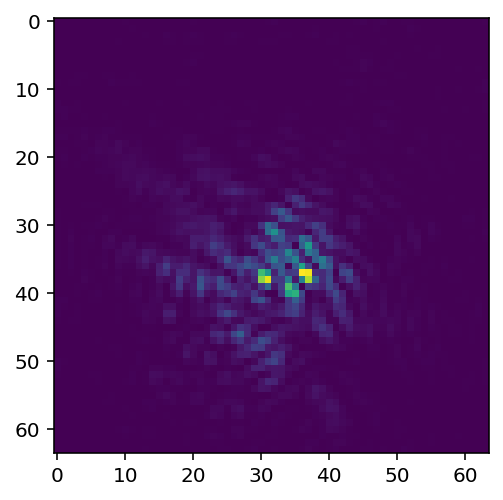

In [178]:
psf_comb = fftPSF(tel, theta_x, theta_y, wavelength, nx=32)
plt.imshow(psf_comb.array)
print(psf_comb.primitiveVectors)

### Raytraced PSF

In [ ]:
wavelength = 622.20 # changing back to nm

observation = {
    'airmass': 1.11434297245889,
    'rawSeeing': 0.816891898166834 * galsim.arcsec,
    'band': 'r',
    'parallactic': 0
    'boresight': galsim.CelestialCoord()
}



class StarSimulator:
    def __init__(
        self,
        observation,  # from OpSim
        telescope,  # batoid.Optic
        rng=None,
    ):
        if rng is None:
            rng = galsim.BaseDeviate()
        self.observation = observation

        self.wavelength = wavelength_dict[observation['band']]
        self.atm = makeAtmosphere(
            observation['airmass'],
            observation['rawSeeing'],
            self.wavelength,
            rng,
        )

        # and pre-cache a 2nd kick
        psf = self.atm.makePSF(self.wavelength, diam=8.36)
        _ = psf.drawImage(nx=1, ny=1, n_photons=1, rng=rng, method='phot')
        self.second_kick = psf.second_kick

        self.bandpass = galsim.Bandpass(
            f"LSST_{observation['band']}.dat", wave_type='nm'
        )
        
        self.telescope = telescope

        # Develop gnomonic projection from ra/dec to field angle using
        # GalSim TanWCS class.
        q = observation['parallactic']
        cq, sq = np.cos(q), np.sin(q)
        affine = galsim.AffineTransform(cq, -sq, sq, cq)
        self.radecToField = galsim.TanWCS(
            affine,
            self.observation['boresight'],
            units=galsim.radians
        )

def simStar(self, coord, sed, nphoton, rng, return_photons=False):
        fieldAngle = self.radecToField.toImage(coord)
        # Populate pupil
        r_outer = 8.36/2
        # purposely underestimate inner radius a bit.
        # Rays that miss will be marked vignetted.
        r_inner = 8.36/2*0.58
        ud = galsim.UniformDeviate(rng)
        r = np.empty(nphoton)
        ud.generate(r)
        r *= (r_outer**2 - r_inner**2)
        r += r_inner**2
        r = np.sqrt(r)

        th = np.empty(nphoton)
        ud.generate(th)
        th *= 2*np.pi
        u = r*np.cos(th)
        v = r*np.sin(th)

        # uniformly distribute photon times throughout 30s exposure
        t = np.empty(nphoton)
        ud.generate(t)
        t *= self.observation['exptime']

        # evaluate phase gradients at appropriate location/time
        dku, dkv = self.atm.wavefront_gradient(
            u, v, t, (fieldAngle.x*galsim.radians, fieldAngle.y*galsim.radians)
        )  # output is in nm per m.  convert to radians
        dku *= 1.e-9
        dkv *= 1.e-9

        # add in second kick
        pa = galsim.PhotonArray(nphoton)
        self.second_kick._shoot(pa, rng)
        dku += pa.x*(galsim.arcsec/galsim.radians)
        dkv += pa.y*(galsim.arcsec/galsim.radians)

        # assign wavelengths.
        wavelengths = sed.sampleWavelength(nphoton, self.bandpass, rng)

        # Chromatic seeing.  Scale deflections by (lam/500)**(-0.3)
        dku *= (wavelengths/500)**(-0.3)
        dkv *= (wavelengths/500)**(-0.3)

        # DCR.  dkv is aligned along meridian, so only need to shift in this
        # direction (I think)
        base_refraction = galsim.dcr.get_refraction(
            self.wavelength,
            self.observation['zenith'],
            temperature=self.observation['temperature'],
            pressure=self.observation['pressure'],
            H2O_pressure=self.observation['H2O_pressure'],
        )
        refraction = galsim.dcr.get_refraction(
            wavelengths,
            self.observation['zenith'],
            temperature=self.observation['temperature'],
            pressure=self.observation['pressure'],
            H2O_pressure=self.observation['H2O_pressure'],
        )
        refraction -= base_refraction
        dkv += refraction

        # We're through the atmosphere!  Make a structure that batoid can use
        # now.  Note we're going to just do the sum in the tangent plane
        # coordinates.  This isn't perfect, but almost certainly good enough to
        # still be interesting.
        dku += fieldAngle.x
        dkv += fieldAngle.y
        vx, vy, vz = batoid.utils.fieldToDirCos(dku, dkv, projection='gnomonic')

        # Place rays on entrance pupil - the planar cap coincident with the rim
        # of M1.  Eventually may want to back rays up further so that they can
        # be obstructed by struts, e.g..
        x = u
        y = v
        zPupil = self.telescope["M1"].surface.sag(0, 0.5*self.telescope.pupilSize)
        z = np.zeros_like(x)+zPupil
        # Rescale velocities so that they're consistent with the current
        # refractive index.
        n = self.telescope.inMedium.getN(wavelengths)
        vx /= n
        vy /= n
        vz /= n
        rays = batoid.RayVector.fromArrays(
            x, y, z, vx, vy, vz, t=np.zeros_like(x), w=wavelengths*1e-9, flux=1
        )

        self.telescope.traceInPlace(rays)

        # Now we need to refract the beam into the Silicon.
        silicon = batoid.TableMedium.fromTxt("silicon_dispersion.txt")
        self.telescope['Detector'].surface.refractInPlace(
            rays,
            self.telescope['Detector'].inMedium,
            silicon, coordSys=self.telescope['Detector'].coordSys
        )

        # Need to convert to pixels for galsim sensor object
        # Put batoid results back into photons
        # Use the same array.
        pa.x = rays.x/10e-6
        pa.y = rays.y/10e-6
        pa.dxdz = rays.vx/rays.vz
        pa.dydz = rays.vy/rays.vz
        pa.wavelength = wavelengths
        pa.flux = ~rays.vignetted

        # sensor = galsim.Sensor()
        sensor = galsim.SiliconSensor()
        image = galsim.Image(256, 256)  # hard code for now
        image.setCenter(
            int(np.mean(pa.x[~rays.vignetted])),
            int(np.mean(pa.y[~rays.vignetted]))
        )
        sensor.accumulate(pa, image)

        if return_photons:
            return image, pa
        else:
            return image